In [31]:
%reload_ext autoreload

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import env
import acquire

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler

from math import sqrt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# from wrangle_zillow import wrangle_zillow
# import explore
# import split_scale
# import features_zillow
# import model_zillow
# import evaluate



In [11]:
np.random.seed(123)
df = acquire.get_zillow_data_from_sql()
df

,bathrooms,bedrooms,square_feet,home_value
0,2.0,3.0,1458.0,136104.0
1,1.0,2.0,1421.0,35606.0
2,3.0,4.0,2541.0,880456.0
3,2.0,3.0,1650.0,614000.0
4,1.0,2.0,693.0,274237.0
...,...,...,...,...
15031,3.0,5.0,2526.0,458903.0
15032,3.0,5.0,2735.0,115387.0
15033,2.0,3.0,1536.0,297097.0
15034,3.0,5.0,2655.0,746963.0


In [12]:
df.shape

(15036, 4)

In [13]:
# Okay, so 15,036 observations 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15036 entries, 0 to 15035
Data columns (total 4 columns):
bathrooms      15036 non-null float64
bedrooms       15036 non-null float64
square_feet    15012 non-null float64
home_value     15036 non-null float64
dtypes: float64(4)
memory usage: 470.0 KB


In [14]:
df.isnull().sum()

bathrooms       0
bedrooms        0
square_feet    24
home_value      0
dtype: int64

#### Looks like 'square_feet' has null values.  Being that the dataset is so large (15,036 rows), it is not likely that dropping 24 of them will have an adverse affect on our projections.

#### First, find out which rows have the nulls in them:

In [15]:
# Checks to see if ANY values in the rows are null

sq_ft_nulls = df[df.isnull().any(axis=1)]["square_feet"]
sq_ft_nulls

280     NaN
920     NaN
921     NaN
940     NaN
2629    NaN
4096    NaN
5553    NaN
6585    NaN
6942    NaN
8514    NaN
8957    NaN
9603    NaN
9797    NaN
11019   NaN
11249   NaN
11544   NaN
11848   NaN
12134   NaN
12305   NaN
12517   NaN
13259   NaN
13791   NaN
13829   NaN
14978   NaN
Name: square_feet, dtype: float64

In [16]:
# tax_amount_nulls = df[df.isnull().any(axis=1)]["tax_amount"]
# tax_amount_nulls

In [17]:
df = df.dropna(how='any',axis=0) 

#### Check to see if that worked

In [18]:
df

,bathrooms,bedrooms,square_feet,home_value
0,2.0,3.0,1458.0,136104.0
1,1.0,2.0,1421.0,35606.0
2,3.0,4.0,2541.0,880456.0
3,2.0,3.0,1650.0,614000.0
4,1.0,2.0,693.0,274237.0
...,...,...,...,...
15031,3.0,5.0,2526.0,458903.0
15032,3.0,5.0,2735.0,115387.0
15033,2.0,3.0,1536.0,297097.0
15034,3.0,5.0,2655.0,746963.0


#### Checking a random row from the 'square_feet' column that should have been dropped:

In [19]:
print(df.loc[[11544]])

KeyError: "None of [Int64Index([11544], dtype='int64')] are in the [index]"

#### Checking the row from 'tax_amount' that should have been dropped

In [20]:
# print(df.loc[[5180]])

In [21]:
df.isnull().sum()

bathrooms      0
bedrooms       0
square_feet    0
home_value     0
dtype: int64

#### Looks good.  The math for the total rows after 24 drops checks out, and none of the rows were available to print. 

## Selecting features 

### Now, the fun part.  What's related, and what's not.  

#### WHOA!  I think that heat map gave me a seizure!  Yikes...  Guess we gotta do this the hard way

In [22]:
df.head()

,bathrooms,bedrooms,square_feet,home_value
0,2.0,3.0,1458.0,136104.0
1,1.0,2.0,1421.0,35606.0
2,3.0,4.0,2541.0,880456.0
3,2.0,3.0,1650.0,614000.0
4,1.0,2.0,693.0,274237.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15012 entries, 0 to 15035
Data columns (total 4 columns):
bathrooms      15012 non-null float64
bedrooms       15012 non-null float64
square_feet    15012 non-null float64
home_value     15012 non-null float64
dtypes: float64(4)
memory usage: 1.2 MB


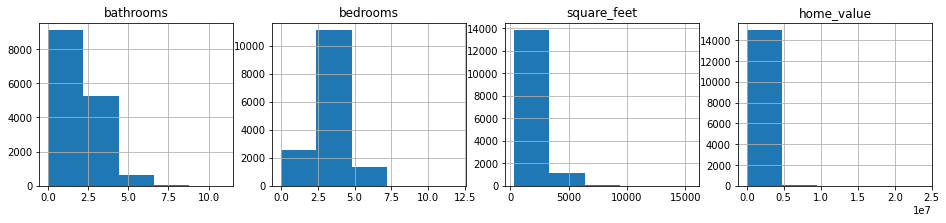

In [24]:
plt.figure(figsize=(16, 3))

for i, col in enumerate(["bathrooms", "bedrooms", "square_feet", "home_value"]):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]  
    plt.subplot(1,4, plot_number)
    plt.title(col)
    series.hist(bins=5)

### Histogram's telling me that the most houses are (roughly) 3.5bdr, 2bath, 2,200sqft and cost about `$`250,000.

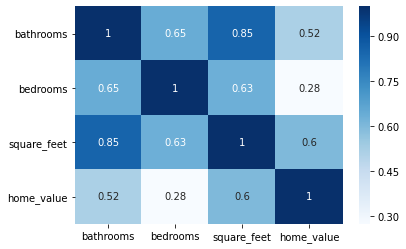

In [25]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="Blues") # Blues chosen in honor of Zillow's color palate

### Heat map's telling me that 'home_value' is most closely correlated to 'square_feet.'

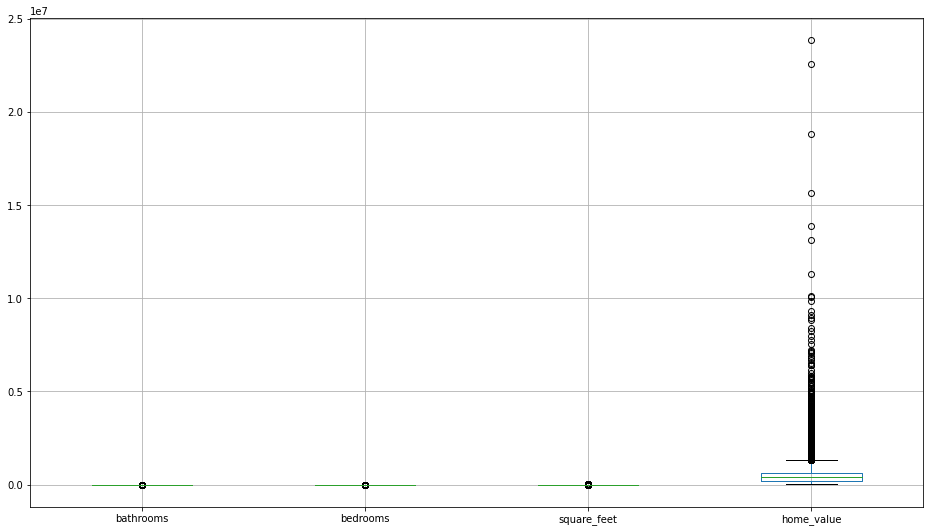

In [30]:
plt.figure(figsize=(16, 9))
df.boxplot(column=["bathrooms", "bedrooms", "square_feet", "home_value"])

# plt.figure(figsize=(8,4))
# sns.boxplot(data=df)

### Ugh.  Box plot tells me nothing other than differing value metrics (smells like scaling).

In [27]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
df = pd.DataFrame(data)
df['Married'] =df['Married'].astype('category').cat.codes
df['Education'] =df['Education'].astype('category').cat.codes
df['Self_Employed'] =df['Self_Employed'].astype('category').cat.codes
df['Area'] =df['Area'].astype('category').cat.codes
df['Loan Status'] =df['Loan Status'].astype('category').cat.codes